<a href="https://colab.research.google.com/github/SongheeJo/aiffelthon/blob/main/Baseline_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Load data**
    1. sampling rate 지정
        
        respireNet에서는 4kHz로 down sampling

    2. librosa.load 사용
    
    load 시 sampling rate 파라미터로 전체 data에 일괄 적용 가능

2. **Pre-processing**
    1. better SNR
        - `tfio.experimental.audio.trim()` tensorflow-io 패키지 노이즈 제거 ⇒ 들어보기
        - split & pad
            - 7초?
            - padding
              tfio.experimental.audio.fade tensorflow-io 패키지 페이딩 기술 ⇒ 현재 data에도 유용할까?
        - butterworth filter
            - `scipy.signal.butter()`

3. **Train_val_test_split**
    1. data imbalance 해결을 위해 파라미터 stratify 조정

4. **Augmentation**
    1. 일단 없이 진행 후 결과 보기
    2. 구현된 기본적인 augmentation 방법 적용해보고 결과 보기
        - 각 방법 별로 얼마나 결과가 좋아졌는지 저장 해둘 것
        - 각각 했을 때 vs 몇 개 같이 했을 때 결과 비교


5. **Feature Extraction**

6. **Build model**
   - transfer learning

7. **Evaluate**
    1. classification report text file 로 저장하는 module 생성
    2. recall 값과 f1 값

## 1. Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import soundfile as sf
import librosa as lb
import os

root = '/content/drive/MyDrive/aiffel/aiffelthon/'

###Data analysis (Disease)
crack & wheeze는 나중에


In [7]:
diagnosis=pd.read_csv(root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [8]:
df=pd.read_csv(root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t', names = ['start', 'end', 'crackles', 'weezels'])
df.head()

,start,end,crackles,weezels
0,1.862,5.718,0,1
1,5.718,9.725,1,1
2,9.725,13.614,0,1
3,13.614,17.671,0,1
4,17.671,19.541,0,0


In [10]:
path=root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b3_Al_mc_AKGC417L',
 '160_1b3_Pr_mc_AKGC417L',
 '160_1b3_Ar_mc_AKGC417L',
 '160_1b3_Tc_mc_AKGC417L',
 '160_1b4_Ar_mc_AKGC417L']

In [9]:
def getFilenameInfo(file):
    return file.split('_')

In [11]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L


In [14]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [15]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 3
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


두 데이터프레임을 merge하기 위해 같은 타입으로 통일해줍니다

In [17]:
diagnosis.pid=diagnosis.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

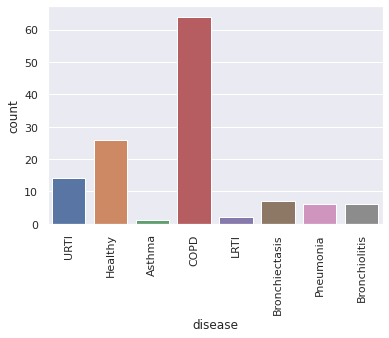

In [18]:
sns.set_theme(style="darkgrid")
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

In [19]:
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L,COPD


In [ ]:
data.to_csv('/content/drive/MyDrive/aiffel/aiffelthon/csv_data/data.csv',index=False)

##2. Pre-processing


###Divide Data
데이터 자르면서 crack_wheeze가 포함된 새로운 컬럼을 만듭니다.

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    '''

    max_ind = len(raw_data) #원본 데이터
    start_ind = min(int(start * sr), max_ind) #시작 시간 x sample rate
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
i,c=0,0

filename2 = []
start2 = []
end2 = []
pid2 = []
mode2 = []
disease2 = []
crack_wheeze = []
for index,row in data.iterrows(): #enumerte 과 비슷
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    audio_file_loc=path + filename + '.wav' #wav 파일 경로 저장
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav' #새로운 파일 이름

    filename2.append(filename)
    start2.append(row['start'])
    end2.append(row['end'])
    pid2.append(row['pid'])
    mode2.append(row['mode'])
    disease2.append(row['disease'])

    if row['crackles'] == 0 and row['weezels'] == 0:
      crack_wheeze.append(0)
    elif row['crackles'] == 1 and row['weezels'] == 0:
      crack_wheeze.append(1)
    elif row['crackles'] == 0 and row['weezels'] == 1:
      crack_wheeze.append(2)
    else:
      crack_wheeze.append(3)
    
    save_path='/content/drive/MyDrive/aiffel/aiffelthon/processed_audio_files_8/' + filename
    c+=1 #파일 개수 세기
    
    audioArr,sampleRate=lb.load(audio_file_loc, sr = 16000)
    pureSample=getPureSample(audioArr,start,end,sampleRate) #잘린 데이터 return, 길이는 상관 없음

    if c % 100 == 0:
      print(c)
    
    
    sf.write(file=save_path,data=pureSample,samplerate=sampleRate)
print('Total Files Processed: ',c)

In [ ]:
processed = pd.DataFrame(columns=['start','end','pid','mode','filename','disease','crack_wheeze'])
processed['start'] = start2
processed['end'] = end2
processed['pid'] = pid2
processed['mode'] = mode2
processed['filename'] = filename2
processed['disease'] = disease2
processed['crack_wheeze'] = crack_wheeze

processed.to_csv(root + 'processed.csv')

In [3]:
processed = pd.read_csv(root + 'processed.csv') #우리가 계속 쓸 컬럼입니다

원하는 길이로 패딩해서 wav로 저장합니다

In [ ]:
sr=16000

def zero_padding(pureSample, reqLen = 7 * sr):
  padded = lb.util.pad_center(pureSample, reqLen)
  return padded

In [ ]:
for index,row in processed.iterrows():
  maxLen=7 #5,6,7 선택
  start=row['start']
  end=row['end']
  filename=row['filename']
    
  audio_file_loc= root + 'processed_audio_files/' + filename #5,6,7 선택
  processed_sample, _ = lb.load(audio_file_loc, sr = sr) #자르고 전처리한 데이터

  #If len > maxLen , change it to maxLen
  if end-start>maxLen:
      end=start+maxLen
      processed_sample = processed_sample[int(start * sr) : int(end * sr)] #초에 맞춰주기
  
  padded_data = zero_padding(processed_sample,7 * sr)
  
  save_path = root + 'processed_audio_files_7sec_22050/' + filename

  sf.write(file=save_path,data=padded_data,samplerate = sr)
  


###butter worth filter()

##3. Train_val_test_split

In [13]:
from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split( #disease 분류
    processed,processed.disease,stratify=processed.disease,random_state=42,test_size=0.2)

Xtrain_1,Xval_1,ytrain_1,yval_1=train_test_split( #crack_wheeze 분류
    processed,processed.crack_wheeze,stratify=processed.crack_wheeze,random_state=42,test_size=0.2)

disease 비율

In [5]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832910
Healthy           0.046756
Pneumonia         0.041319
URTI              0.035158
Bronchiolitis     0.023197
Bronchiectasis    0.015042
LRTI              0.004712
Asthma            0.000906
Name: disease, dtype: float64

crackle & wheeze 비율

In [6]:
Xtrain_1.crack_wheeze.value_counts()/Xtrain_1.shape[0]

0    0.527909
1    0.270207
2    0.128489
3    0.073396
Name: crack_wheeze, dtype: float64

In [ ]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')

label 인코딩
- disease 라벨에만 적용 시킵니다
- crackle & wheeze 라벨은 이미 int로 되어있습니다

In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

##4. Augmentation(추후 추가)


##5. Feature Extraction

- Mel spectrogram

In [6]:
def getFeatures(path):
    soundArr,sr=lb.load(path)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sr) #sr=16000
    return mSpec

**default 값**

sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', power=2.0,

In [8]:
root_path= root + 'processed_audio_files_7sec_22050/'
mSpec_v=[]
for idx,row in Xval.iterrows():
    path=root_path + row['filename']
    c=getFeatures(path)
    mSpec_v.append(c)

mSpec_val=np.array(mSpec_v)

In [11]:
mSpec_val.shape

(1380, 128, 302)

In [14]:
root_path= root + 'processed_audio_files_7sec_22050/'
mSpec_t=[]
for idx,row in Xtrain.iterrows():
    path=root_path + row['filename']
    c=getFeatures(path)
    mSpec_t.append(c)

mSpec_train=np.array(mSpec_t)

In [15]:
np.save(root + 'Mel_spectrogram_train_7sec.npy',mSpec_train)
np.save(root + 'Mel_spectrogram_val_7sec.npy',mSpec_train)

In [5]:
mSpec_train = np.load(root + 'Mel_spectrogram_train_7sec.npy')
mSpec_val = np.load(root + 'Mel_spectrogram_val_7sec.npy')

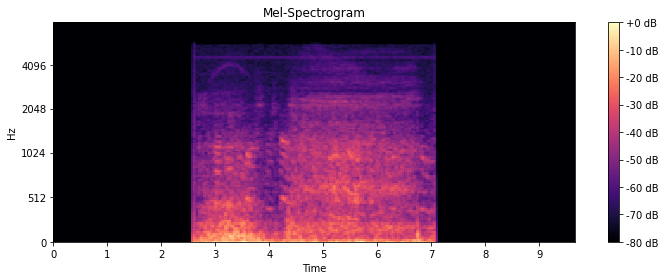

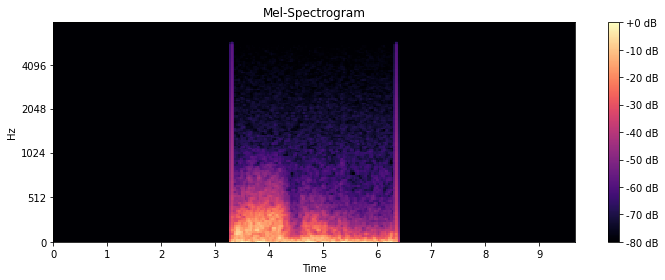

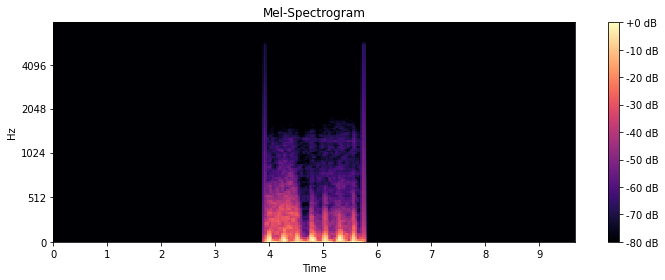

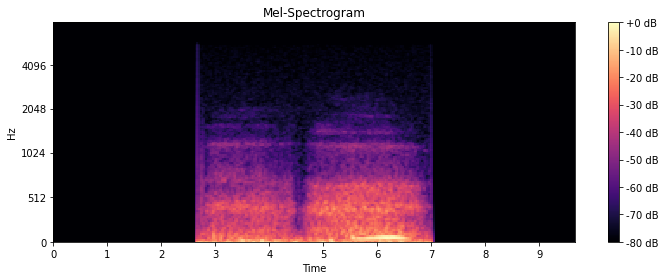

In [7]:
sr=16000
randFiles = [10 * x for x in range(1,5)]

for i,audioFile in enumerate(randFiles):
  
  plt.figure(figsize=(10, 4))
  plt.title('Mel-Spectrogram') 
  librosa.display.specshow(
      librosa.power_to_db(mSpec_train[audioFile], ref=np.max), y_axis='mel', sr=sr, hop_length=512, x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  
  plt.tight_layout()
  plt.savefig('Mel-Spectrogram example.png')
  plt.show()

##6. Build model

- Depthwise Convolution
- ResNet
- Efficient Net

disese model

In [8]:
mSpec_input=keras.layers.Input(shape=(128,302,1),name="mSpecInput")

x = keras.layers.Conv2D(
                filters=32,
                kernel_size=5,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(mSpec_input)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(1,2),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=96,
                kernel_size=2,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=128,
                kernel_size=2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(8,activation='softmax')(x)

mSpec_model=keras.Model(mSpec_input, output, name="mSpecModel")

In [9]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 302, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 101, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 4, 96)          2

crack & wheeze model

In [22]:
mSpec_input=keras.layers.Input(shape=(128,302,1),name="mSpecInput")

x = keras.layers.Conv2D(
                filters=32,
                kernel_size=5,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(mSpec_input)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(1,2),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=96,
                kernel_size=2,
                strides=(2,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(
                filters=128,
                kernel_size=2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same'
            )(x)

x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(4,activation='softmax')(x) #class 변화 주의

mSpec_model_cw=keras.Model(mSpec_input, output, name="mSpecModel")

###training(disease)

In [10]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [11]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/checkpoint-only-zero-7sec-001.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [15]:
history=mSpec_model.fit(
    mSpec_train, # fit 할 때 ndarray > tensor로 바꾸는 느낌?
    ytrain,
    validation_data=(mSpec_val,yval),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
173/173 [==============================] - 17s 18ms/step - loss: 27.6935 - sparse_categorical_accuracy: 0.6665 - val_loss: 3.4452 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 2/100
173/173 [==============================] - 3s 15ms/step - loss: 3.3318 - sparse_categorical_accuracy: 0.7532 - val_loss: 1.1296 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 3/100
173/173 [==============================] - 3s 15ms/step - loss: 1.8807 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.8136 - val_sparse_categorical_accuracy: 0.8326 - lr: 0.0010
Epoch 4/100
173/173 [==============================] - 3s 15ms/step - loss: 1.4743 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.7762 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
173/173 [==============================] - 3s 15ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
173/173 [==

In [17]:
y_pred = mSpec_model.predict(mSpec_val)

###training(crackle & wheeze)

In [25]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model_cw.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model_cw.optimizer.learning_rate, 0.001)

In [23]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/checkpoint-only-zero-7sec-cw-001.h5'
my_callbacks_1 = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [26]:
history=mSpec_model_cw.fit(
    mSpec_train, # fit 할 때 ndarray > tensor로 바꾸는 느낌?
    ytrain_1,
    validation_data=(mSpec_val,yval_1),
    epochs=100,verbose=1,
    callbacks=my_callbacks_1
)

Epoch 1/100
173/173 [==============================] - 4s 17ms/step - loss: 44.5667 - sparse_categorical_accuracy: 0.4014 - val_loss: 1.2621 - val_sparse_categorical_accuracy: 0.5319 - lr: 0.0010
Epoch 2/100
173/173 [==============================] - 3s 15ms/step - loss: 2.2065 - sparse_categorical_accuracy: 0.5116 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 3/100
173/173 [==============================] - 3s 15ms/step - loss: 1.5845 - sparse_categorical_accuracy: 0.5227 - val_loss: 1.1612 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 4/100
173/173 [==============================] - 3s 16ms/step - loss: 1.4064 - sparse_categorical_accuracy: 0.5256 - val_loss: 1.1524 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 5/100
173/173 [==============================] - 3s 15ms/step - loss: 1.2278 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.5283 - lr: 0.0010
Epoch 6/100
173/173 [===

In [29]:
y_pred_1 = mSpec_model_cw.predict(mSpec_val)

##7. Evaluate
disease

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(np.argmax(y_pred, axis = 1), yval)

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   1,   21,   32, 1150,   64,    6,   57,   49],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [21]:
from sklearn.metrics import classification_report

target_names=['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis', 'Pheumonia', 'Bronchiolitis']

with open( root+ "clf_report_zero_7sec.txt", "w") as text_file:
    print(classification_report(yval, np.argmax(y_pred, axis = 1), target_names=target_names), file=text_file)

print(classification_report(yval, np.argmax(y_pred, axis = 1), target_names=target_names))

                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00         1
       Healthy       0.00      0.00      0.00        21
        Asthma       0.00      0.00      0.00        32
          COPD       0.83      1.00      0.91      1150
          LRTI       0.00      0.00      0.00        64
Bronchiectasis       0.00      0.00      0.00         6
     Pheumonia       0.00      0.00      0.00        57
 Bronchiolitis       0.00      0.00      0.00        49

      accuracy                           0.83      1380
     macro avg       0.10      0.12      0.11      1380
  weighted avg       0.69      0.83      0.76      1380



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

crackle & wheeze

In [30]:
confusion_matrix(np.argmax(y_pred_1, axis = 1), yval_1)

array([[729, 373, 177, 101],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

In [31]:
target_names=['Normal', 'crackle', 'wheeze', 'both']

with open( root+ "clf_report_zero_7sec_cw.txt", "w") as text_file:
    print(classification_report(yval_1, np.argmax(y_pred_1, axis = 1), target_names=target_names), file=text_file)

print(classification_report(yval_1, np.argmax(y_pred_1, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.53      1.00      0.69       729
     crackle       0.00      0.00      0.00       373
      wheeze       0.00      0.00      0.00       177
        both       0.00      0.00      0.00       101

    accuracy                           0.53      1380
   macro avg       0.13      0.25      0.17      1380
weighted avg       0.28      0.53      0.37      1380



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat